# Study of the physical dataset

In this notebook, we will study how different models perform on the physical dataset. Some of the models we will study are:
1. Non-supervised:
    - Isolation Forest (IF)
    - Local Outlier Factor (LOF)
2. Neural physicals:
    - DNN
    - LSTM
3. Supervised classifiers:
    - Decision Tree
    - Random Forest
    - XGBoost

First, let's import the necessary libraries.

In [1]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_physical_dataset, remove_physical_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.activations import swish, sigmoid, softmax

BASE_PATH = "../../data/"
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

2023-11-06 20:40:02.378686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load and prepare the dataset

We have defined multiple preprocessing functions in the `preprocessing.py` file. We will use them to load and prepare the dataset.

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=False)
_, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Physical dataset shape: ", df_physical.shape)

Physical dataset shape:  (9206, 44)


This dataset has way fewer rows than the network one, this might cause some problems later.

In [3]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical)
df_physical_prepared.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


The features are :
- `time`: the timestamp of the measurement
- `tank_X`: the level of the tank X
- `pump_Y`: the level of the pump Y
- `valv_Z`: the level of the valve Z

In [4]:
df_physical_labels.head()

,label_n,label,attack,new_labels
0,0.0,normal,1,2
1,0.0,normal,1,2
2,0.0,normal,1,2
3,0.0,normal,1,2
4,0.0,normal,1,2


# Models analysis

## 1. Non-supervised models

### a. Isolation Forest

As a first step, let's try default parameters for the Isolation Forest model.

In [5]:
df_physical_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

In [6]:
clf = IsolationForest(random_state=42)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


6177

In [7]:
df_physical_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

In [8]:
df_physical_labels.iloc[if_outliers]["label_n"].value_counts()

label_n
0.0    4997
1.0    1180
Name: count, dtype: int64

Out of the 6177 outliers found, 1180 are real anomalies (19%). This is not a great result knowing there are only 1459 outliers, let's see if we can do better with a fixed contamination rate.

In [9]:
val_counts_labels = df_physical_labels["label_n"].value_counts()
contamination_rate = val_counts_labels[1] / (val_counts_labels[0] + val_counts_labels[1])
contamination_rate

0.1584835976537041

In [10]:
clf = IsolationForest(n_estimators=100, n_jobs=-1, bootstrap=True, random_state=42, contamination=contamination_rate)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers_cr = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers_cr)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse

1459

In [11]:
df_physical_labels.iloc[if_outliers_cr]["label_n"].value_counts()

label_n
0.0    940
1.0    519
Name: count, dtype: int64

With a fixed contamination rate, the model gets a total of 1459 outliers, out of which 519 are real anomalies (35.5%). This is a better result than with the default parameters and less false positives are found.

### b. Local Outlier Factor

In [12]:
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit_predict(df_physical_prepared)
lof_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(lof_outliers)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


71

In [13]:
df_physical_labels.iloc[lof_outliers]["label_n"].value_counts()

label_n
0.0    47
1.0    24
Name: count, dtype: int64

We get terrible results, it barely detects outliers. This model isn't suited for the dataset.

## 2. Neural Networks

### a. DNN

We will use only some of the columns for the DNN model. We are removing contextual information such as the time. To make it easier to manipulate, we will merge back the labels with the predictions.

#### Binary classification

In [14]:
df = df_physical_prepared.copy()
df["label_n"] = df_physical_labels["label_n"]
df.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [15]:
# convert bool columns to int
bool_cols = df.columns[df.dtypes == bool]
df[bool_cols] = df[bool_cols].astype(int)

# remove time column
if "Time" in df.columns:
    df.drop(columns=['Time'], inplace=True)

# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_n'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label_n'])

# Separate features and target
X_train = train_df.drop(columns=['label_n'])
y_train = train_df['label_n']
X_val = val_df.drop(columns=['label_n'])
y_val = val_df['label_n']
X_test = test_df.drop(columns=['label_n'])
y_test = test_df['label_n']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_

((5891, 41), (1473, 41), (1842, 41))

In [16]:
X_train[0]

array([-1.8453872 ,  0.80077463,  1.38978397, -0.31653682, -0.80836626,
       -1.32533143, -0.10188866,  2.305095  , -0.92628226,  1.33125328,
        1.85997322,  0.        , -0.51106364,  1.29715255, -0.77736917,
        1.29761189, -0.77821244,  0.        , -0.75693134,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.2205967 , -1.2205967 ,
       -1.22016572, -0.82129835, -0.82129835, -0.82158816,  0.        ,
        0.91201897, -0.55179071,  0.        , -1.33567454,  0.        ,
       -0.91326873])

In [17]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(1, activation=sigmoid)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              43008     
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 321921 (1.23 MB)
Trainable params: 321921 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's define callbacks and train the model.

In [18]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40
24/24 [==============================] - 2s 15ms/step - loss: 0.4515 - accuracy: 0.8121 - val_loss: 0.3573 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 2/40
24/24 [==============================] - 0s 7ms/step - loss: 0.3665 - accuracy: 0.8459 - val_loss: 0.3299 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 3/40
24/24 [==============================] - 0s 7ms/step - loss: 0.3091 - accuracy: 0.8644 - val_loss: 0.2764 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 4/40
24/24 [==============================] - 0s 7ms/step - loss: 0.3050 - accuracy: 0.8588 - val_loss: 0.2808 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 5/40
24/24 [==============================] - 0s 7ms/step - loss: 0.2901 - accuracy: 0.8800 - val_loss: 0.2559 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 6/40
24/24 [==============================] - 0s 7ms/step - loss: 0.2459 - accuracy: 0.8958 - val_loss: 0.2275 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 7/40
24/24 [==============================] - 0s 7ms/step - loss: 0.2361 - 

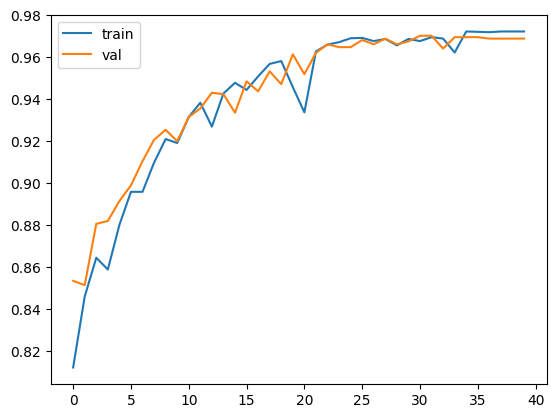

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluation on the test set:

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

58/58 [==============================] - 0s 1ms/step - loss: 0.1010 - accuracy: 0.9674
Test accuracy: 96.74%


In [21]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred)

    # normalize it
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    if title:
        ax.set_title(title)
    plt.show()

58/58 [==============================] - 0s 2ms/step


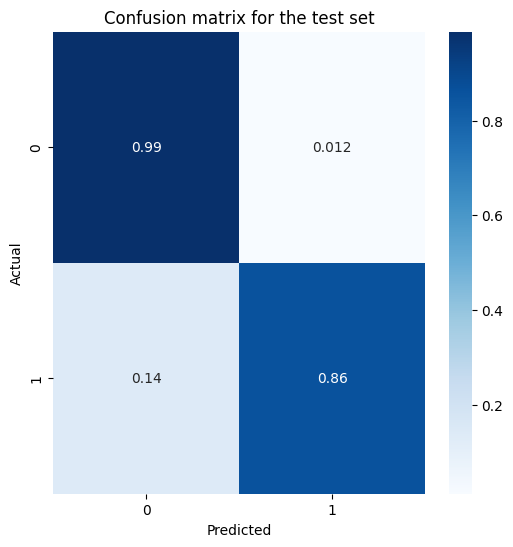

In [22]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

The results are promising, we get a good recall and precision. The model is able to detect 85% of the anomalies and has a low false positive rate. However we still have a lot of false negatives.

#### Multiclass classification

Now, we want to create an alternative DNN which will give us more precision on the type of attack. We will use the same architecture as before, but we will change the output layer to have 5 neurons, one for each type of attack.

In [23]:
df.drop(columns=['label_n'], inplace=True)
df["new_labels"] = df_physical_labels["new_labels"]
df["new_labels"].value_counts()

new_labels
2    7747
1     743
3     552
0     157
4       7
Name: count, dtype: int64

The 5th class has only 7 rows, which is not enough to train a model. We will remove it from the dataset.

In [24]:
# let's remove the 5th class
df = df[df["new_labels"] != 4]

In [95]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['new_labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['new_labels'])

# Separate features and target
X_train = train_df.drop(columns=['new_labels'])
y_train = train_df['new_labels']
X_val = val_df.drop(columns=['new_labels'])
y_val = val_df['new_labels']
X_test = test_df.drop(columns=['new_labels'])
y_test = test_df['new_labels']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_

((5887, 41), (1472, 41), (1840, 41))

In [189]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(5, activation=softmax)  # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 1024)              43008     
                                                                 
 dense_33 (Dense)            (None, 256)               262400    
                                                                 
 dense_34 (Dense)            (None, 64)                16448     
                                                                 
 dense_35 (Dense)            (None, 5)                 325       
                                                                 
Total params: 322181 (1.23 MB)
Trainable params: 322181 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [190]:
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40
23/23 [==============================] - 1s 19ms/step - loss: 0.7883 - accuracy: 0.8035 - val_loss: 0.4627 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - 0s 10ms/step - loss: 0.3854 - accuracy: 0.8734 - val_loss: 0.3557 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - 0s 8ms/step - loss: 0.2973 - accuracy: 0.8850 - val_loss: 0.2917 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 4/40
23/23 [==============================] - 0s 8ms/step - loss: 0.2359 - accuracy: 0.9088 - val_loss: 0.2412 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 5/40
23/23 [==============================] - 0s 7ms/step - loss: 0.1954 - accuracy: 0.9258 - val_loss: 0.2048 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 6/40
23/23 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9339 - val_loss: 0.1764 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 7/40
23/23 [==============================] - 0s 12ms/step - loss: 0.1470 

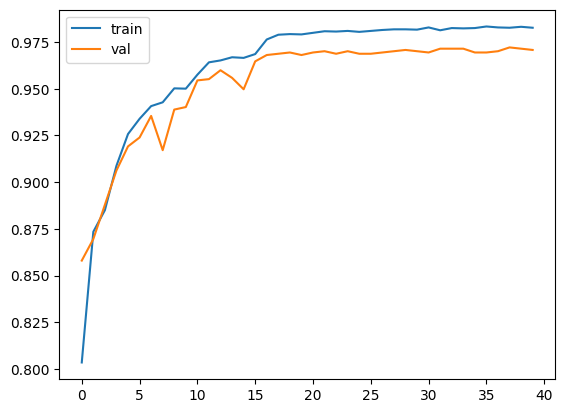

In [191]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluate on the test set:

In [192]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

58/58 [==============================] - 0s 2ms/step - loss: 0.0740 - accuracy: 0.9772
Test accuracy: 97.72%


58/58 [==============================] - 0s 2ms/step


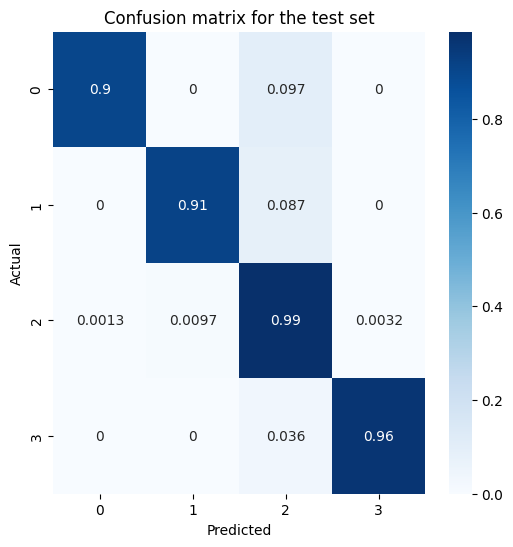

In [193]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = y_pred = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

In [194]:
# get recall, precision, f1-score, and accuracy
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("F1-score: ", f1_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Recall:  0.9413550748883073
Precision:  0.9440076608257726
F1-score:  0.9426045845042144
Accuracy:  0.9771739130434782


The model has better results overall with 98% accuracy. The number of false negatives has been significantly reduced, but we still have a lot of false positives. We could say this is an improvement from before, as it's generally better for security to have false positives than false negatives.

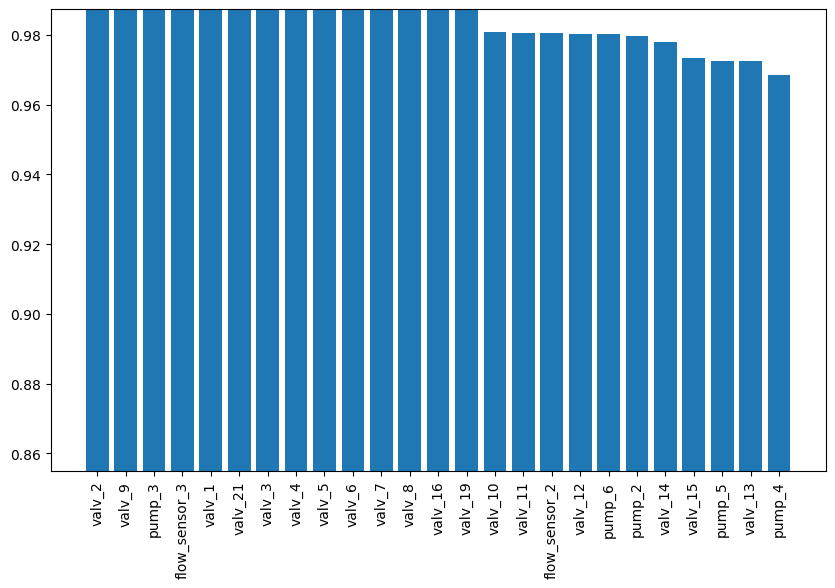

In [117]:
# feature importance for the network
def get_feature_importance(model, X_train, y_train):
    # get feature importance
    feature_importance = np.zeros(X_train.shape[1])
    for i in range(X_train.shape[1]):
        X_train_perm = X_train.copy()
        np.random.shuffle(X_train_perm[:, i])
        feature_importance[i] = model.evaluate(X_train_perm, y_train, verbose=0)[1]
    return feature_importance

feature_importance = get_feature_importance(model, X_train, y_train)

# plot top 25 features
topk = 25
top_features = np.argsort(feature_importance)[::-1][:topk]
plt.figure(figsize=(10, 6))
plt.bar(range(topk), feature_importance[top_features])
plt.xticks(range(topk), df.columns[top_features], rotation=90)
# scale down y-axis
plt.ylim(feature_importance.min(), feature_importance.max())
plt.show()

Many features seems to be as important as the others. This tells us that the model is not overfitting and that the features are all relevant.

#### Adversarial attacks

Let's try to look at the robustness of our model against adversarial attacks

In [195]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from copy import deepcopy
# let's duplicate the model
model_copy = deepcopy(model)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

classifier = TensorFlowV2Classifier(model=model_copy, nb_classes=5, input_shape=(X_train.shape[0],), loss_object=loss, optimizer=optimizer, clip_values=(X_train.min(), X_train.max()))

# no need to fit the model again as we have a copy of the original model already fitted
#classifier.fit(X_train, y_train, epochs=40, batch_size=256)

In [196]:
# let's verify we still have the same accuracy
predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.71739130434783%


In [197]:
# Generate adversarial test examples by using Fast Gradient Method
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=X_test)

In [198]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 44.67391304347826%


In [199]:
model.evaluate(x_test_adv, y_test)

58/58 [==============================] - 0s 2ms/step - loss: 2.6103 - accuracy: 0.4467


[2.610321521759033, 0.446739137172699]

We can see that the accuracy dropped from 97% to 44.7% on the attack exemples.
Let's see if we fine tune our base model with the adversarial attacks if we can make it robuster

In [200]:
x_train_adv = attack.generate(x=X_train)
x_train_adv.shape

(5887, 41)

In [201]:
history_fine_tune = model.fit(x_train_adv, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
23/23 [==============================] - 0s 12ms/step - loss: 1.5132 - accuracy: 0.7156 - val_loss: 0.3319 - val_accuracy: 0.9069
Epoch 2/10
23/23 [==============================] - 0s 9ms/step - loss: 0.6392 - accuracy: 0.8193 - val_loss: 0.1733 - val_accuracy: 0.9341
Epoch 3/10
23/23 [==============================] - 0s 15ms/step - loss: 0.3793 - accuracy: 0.8653 - val_loss: 0.1687 - val_accuracy: 0.9293
Epoch 4/10
23/23 [==============================] - 0s 12ms/step - loss: 0.2780 - accuracy: 0.8952 - val_loss: 0.1564 - val_accuracy: 0.9361
Epoch 5/10
23/23 [==============================] - 0s 10ms/step - loss: 0.2222 - accuracy: 0.9171 - val_loss: 0.1553 - val_accuracy: 0.9341
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.1871 - accuracy: 0.9293 - val_loss: 0.1525 - val_accuracy: 0.9348
Epoch 7/10
23/23 [==============================] - 0s 8ms/step - loss: 0.1613 - accuracy: 0.9377 - val_loss: 0.1503 - val_accuracy: 0.9361
Epoch 8/10
23/23

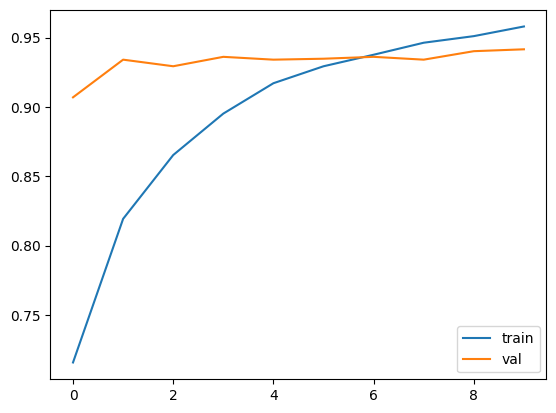

In [202]:
plt.plot(history_fine_tune.history['accuracy'], label='train')
plt.plot(history_fine_tune.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [203]:
model.evaluate(X_test, y_test)

58/58 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9484


[0.13395340740680695, 0.948369562625885]

In [204]:
model.evaluate(x_test_adv, y_test)

58/58 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9462


[0.13724221289157867, 0.946195662021637]

We 've lost 2% on the accuracy on normal exemple but we improved from 0.47 to 0.94 on adversarial sample which means that our model is way more robust now.

### b. LSTM

#### Binary classification

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_

Let's create a PyTorch dataset

In [35]:
class HITLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HITLDataset(X_train_scaled, y_train["label_n"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["label_n"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["label_n"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["label_n"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(41, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for X, y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item()

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, total=len(val_loader)):
            y_pred = model(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            val_acc += (y_pred.argmax(1) == y).sum().item()
    return train_loss / len(train_loader), train_acc / len(train_loader.dataset), val_loss / len(val_loader), val_acc / len(val_loader.dataset)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item()
            y_pred_list.append(y_pred.argmax(1).cpu().numpy())
            y_true_list.append(y.cpu().numpy())
    return test_loss / len(test_loader), test_acc / len(test_loader.dataset)

  0%|          | 0/185 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:00<00:00, 1347.40it/s]


Train loss: 0.4559, Train acc: 0.8374, Val loss: 0.4211, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1611.57it/s]


Train loss: 0.3887, Train acc: 0.8477, Val loss: 0.3724, Val acc: 0.8398


100%|██████████| 47/47 [00:00<00:00, 1720.12it/s]


Train loss: 0.3428, Train acc: 0.8632, Val loss: 0.3267, Val acc: 0.8690


100%|██████████| 47/47 [00:00<00:00, 1669.03it/s]


Train loss: 0.3002, Train acc: 0.8825, Val loss: 0.2892, Val acc: 0.8832


100%|██████████| 47/47 [00:00<00:00, 1796.72it/s]


Train loss: 0.2738, Train acc: 0.8878, Val loss: 0.2655, Val acc: 0.8893


100%|██████████| 47/47 [00:00<00:00, 1721.05it/s]


Train loss: 0.2500, Train acc: 0.8968, Val loss: 0.2433, Val acc: 0.8975


100%|██████████| 47/47 [00:00<00:00, 1831.88it/s]


Train loss: 0.2291, Train acc: 0.9041, Val loss: 0.2199, Val acc: 0.9158


100%|██████████| 47/47 [00:00<00:00, 1031.29it/s]


Train loss: 0.2143, Train acc: 0.9107, Val loss: 0.2107, Val acc: 0.9131


100%|██████████| 47/47 [00:00<00:00, 1663.18it/s]


Train loss: 0.2012, Train acc: 0.9161, Val loss: 0.2089, Val acc: 0.9246


100%|██████████| 47/47 [00:00<00:00, 1623.77it/s]


Train loss: 0.1911, Train acc: 0.9219, Val loss: 0.1811, Val acc: 0.9206


100%|██████████| 47/47 [00:00<00:00, 1851.70it/s]


Train loss: 0.1812, Train acc: 0.9275, Val loss: 0.1770, Val acc: 0.9233


100%|██████████| 47/47 [00:00<00:00, 1744.36it/s]


Train loss: 0.1709, Train acc: 0.9299, Val loss: 0.1658, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1839.38it/s]


Train loss: 0.1655, Train acc: 0.9321, Val loss: 0.1618, Val acc: 0.9335


100%|██████████| 47/47 [00:00<00:00, 1306.10it/s]


Train loss: 0.1593, Train acc: 0.9369, Val loss: 0.1587, Val acc: 0.9314


100%|██████████| 47/47 [00:00<00:00, 1658.13it/s]


Train loss: 0.1539, Train acc: 0.9360, Val loss: 0.1492, Val acc: 0.9355


100%|██████████| 47/47 [00:00<00:00, 1243.26it/s]


Train loss: 0.1486, Train acc: 0.9382, Val loss: 0.1475, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1486.56it/s]


Train loss: 0.1412, Train acc: 0.9425, Val loss: 0.1520, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1697.56it/s]


Train loss: 0.1383, Train acc: 0.9421, Val loss: 0.1388, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1539.99it/s]


Train loss: 0.1348, Train acc: 0.9477, Val loss: 0.1369, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1421.57it/s]


Train loss: 0.1314, Train acc: 0.9477, Val loss: 0.1362, Val acc: 0.9457


100%|██████████| 47/47 [00:00<00:00, 1631.03it/s]


Train loss: 0.1279, Train acc: 0.9489, Val loss: 0.1290, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1791.92it/s]


Train loss: 0.1251, Train acc: 0.9506, Val loss: 0.1315, Val acc: 0.9484


100%|██████████| 47/47 [00:00<00:00, 1279.51it/s]


Train loss: 0.1251, Train acc: 0.9492, Val loss: 0.1260, Val acc: 0.9457


100%|██████████| 47/47 [00:00<00:00, 1750.78it/s]


Train loss: 0.1201, Train acc: 0.9521, Val loss: 0.1219, Val acc: 0.9484


100%|██████████| 47/47 [00:00<00:00, 1412.39it/s]


Train loss: 0.1169, Train acc: 0.9569, Val loss: 0.1205, Val acc: 0.9552


100%|██████████| 47/47 [00:00<00:00, 1609.97it/s]


Train loss: 0.1182, Train acc: 0.9538, Val loss: 0.1527, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1625.61it/s]


Train loss: 0.1130, Train acc: 0.9552, Val loss: 0.1181, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 1594.79it/s]


Train loss: 0.1106, Train acc: 0.9581, Val loss: 0.1162, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1625.62it/s]


Train loss: 0.1075, Train acc: 0.9588, Val loss: 0.1151, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 1390.54it/s]


Train loss: 0.1049, Train acc: 0.9596, Val loss: 0.1145, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1533.48it/s]


Train loss: 0.1038, Train acc: 0.9591, Val loss: 0.1120, Val acc: 0.9552


100%|██████████| 47/47 [00:00<00:00, 1607.45it/s]


Train loss: 0.1019, Train acc: 0.9606, Val loss: 0.1204, Val acc: 0.9545


100%|██████████| 47/47 [00:00<00:00, 1620.74it/s]


Train loss: 0.1027, Train acc: 0.9598, Val loss: 0.1097, Val acc: 0.9511


100%|██████████| 47/47 [00:00<00:00, 1547.93it/s]


Train loss: 0.0986, Train acc: 0.9623, Val loss: 0.1091, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1448.61it/s]


Train loss: 0.0974, Train acc: 0.9620, Val loss: 0.1116, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1417.85it/s]


Train loss: 0.0953, Train acc: 0.9635, Val loss: 0.1101, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1752.49it/s]


Train loss: 0.0964, Train acc: 0.9654, Val loss: 0.1035, Val acc: 0.9654


100%|██████████| 47/47 [00:00<00:00, 1330.29it/s]


Train loss: 0.0923, Train acc: 0.9659, Val loss: 0.1027, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1793.42it/s]


Train loss: 0.0913, Train acc: 0.9650, Val loss: 0.1018, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1733.29it/s]


Train loss: 0.0891, Train acc: 0.9694, Val loss: 0.1029, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1645.70it/s]


Train loss: 0.0875, Train acc: 0.9674, Val loss: 0.1038, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1626.41it/s]


Train loss: 0.0886, Train acc: 0.9655, Val loss: 0.1020, Val acc: 0.9566


100%|██████████| 47/47 [00:00<00:00, 1773.12it/s]


Train loss: 0.0870, Train acc: 0.9655, Val loss: 0.1007, Val acc: 0.9545


100%|██████████| 47/47 [00:00<00:00, 1765.86it/s]


Train loss: 0.0869, Train acc: 0.9676, Val loss: 0.0968, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1741.57it/s]


Train loss: 0.0834, Train acc: 0.9667, Val loss: 0.0952, Val acc: 0.9654


100%|██████████| 47/47 [00:00<00:00, 1579.41it/s]


Train loss: 0.0838, Train acc: 0.9684, Val loss: 0.0928, Val acc: 0.9627


100%|██████████| 47/47 [00:00<00:00, 1576.16it/s]


Train loss: 0.0807, Train acc: 0.9713, Val loss: 0.0993, Val acc: 0.9606


100%|██████████| 47/47 [00:00<00:00, 1774.24it/s]


Train loss: 0.0804, Train acc: 0.9681, Val loss: 0.0929, Val acc: 0.9613


100%|██████████| 47/47 [00:00<00:00, 1591.02it/s]


Train loss: 0.0826, Train acc: 0.9693, Val loss: 0.0960, Val acc: 0.9661


100%|██████████| 47/47 [00:00<00:00, 1296.49it/s]


Train loss: 0.0794, Train acc: 0.9691, Val loss: 0.0949, Val acc: 0.9654


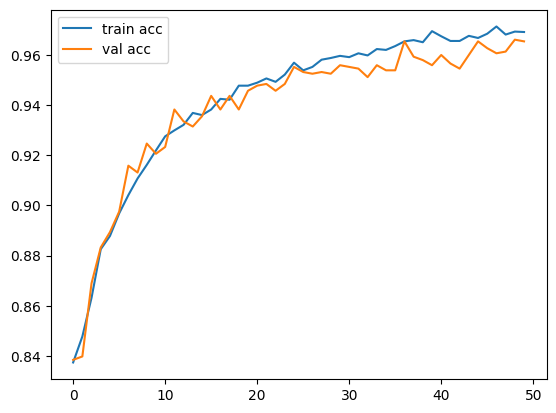

In [39]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [40]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.0881, Test acc: 0.9631


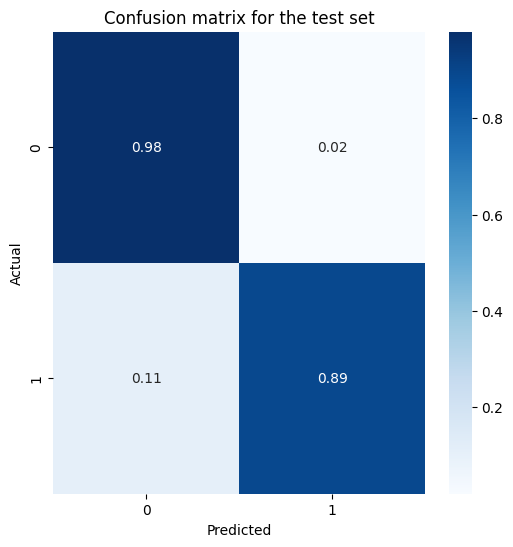

In [43]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

The binary class LSTM has a lot of false negatives, just like the DNN, let's see if the multiclass LSTM can do better.

#### Multiclass classification

In [44]:
train_dataset = HITLDataset(X_train_scaled, y_train["new_labels"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["new_labels"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["new_labels"].to_numpy())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [45]:
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["new_labels"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 47/47 [00:00<00:00, 1342.39it/s]


Train loss: 0.8677, Train acc: 0.7449, Val loss: 0.6449, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1270.27it/s]


Train loss: 0.5596, Train acc: 0.8474, Val loss: 0.5522, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1305.51it/s]


Train loss: 0.5080, Train acc: 0.8471, Val loss: 0.4942, Val acc: 0.8405


100%|██████████| 47/47 [00:00<00:00, 1205.07it/s]


Train loss: 0.4663, Train acc: 0.8508, Val loss: 0.4587, Val acc: 0.8486


100%|██████████| 47/47 [00:00<00:00, 1381.78it/s]


Train loss: 0.4298, Train acc: 0.8576, Val loss: 0.4252, Val acc: 0.8527


100%|██████████| 47/47 [00:00<00:00, 1236.82it/s]


Train loss: 0.4048, Train acc: 0.8673, Val loss: 0.4047, Val acc: 0.8697


100%|██████████| 47/47 [00:00<00:00, 1342.68it/s]


Train loss: 0.3836, Train acc: 0.8769, Val loss: 0.4131, Val acc: 0.8710


100%|██████████| 47/47 [00:00<00:00, 1270.22it/s]


Train loss: 0.3600, Train acc: 0.8781, Val loss: 0.3666, Val acc: 0.8771


100%|██████████| 47/47 [00:00<00:00, 1424.28it/s]


Train loss: 0.3469, Train acc: 0.8805, Val loss: 0.3447, Val acc: 0.8873


100%|██████████| 47/47 [00:00<00:00, 894.00it/s]


Train loss: 0.3247, Train acc: 0.8858, Val loss: 0.3252, Val acc: 0.8873


100%|██████████| 47/47 [00:00<00:00, 1236.80it/s]


Train loss: 0.3116, Train acc: 0.8863, Val loss: 0.3383, Val acc: 0.8887


100%|██████████| 47/47 [00:00<00:00, 1342.84it/s]


Train loss: 0.3001, Train acc: 0.8890, Val loss: 0.2954, Val acc: 0.9002


100%|██████████| 47/47 [00:00<00:00, 1270.27it/s]


Train loss: 0.2820, Train acc: 0.8932, Val loss: 0.2968, Val acc: 0.8934


100%|██████████| 47/47 [00:00<00:00, 1119.66it/s]


Train loss: 0.2701, Train acc: 0.8975, Val loss: 0.2680, Val acc: 0.9077


100%|██████████| 47/47 [00:00<00:00, 939.98it/s]


Train loss: 0.2568, Train acc: 0.9054, Val loss: 0.2623, Val acc: 0.9050


100%|██████████| 47/47 [00:00<00:00, 691.20it/s]


Train loss: 0.2537, Train acc: 0.9070, Val loss: 0.2584, Val acc: 0.9145


100%|██████████| 47/47 [00:00<00:00, 1119.04it/s]


Train loss: 0.2388, Train acc: 0.9116, Val loss: 0.2404, Val acc: 0.9117


100%|██████████| 47/47 [00:00<00:00, 722.89it/s]


Train loss: 0.2287, Train acc: 0.9173, Val loss: 0.2319, Val acc: 0.9165


100%|██████████| 47/47 [00:00<00:00, 921.60it/s]


Train loss: 0.2205, Train acc: 0.9197, Val loss: 0.2254, Val acc: 0.9226


100%|██████████| 47/47 [00:00<00:00, 691.15it/s]


Train loss: 0.2113, Train acc: 0.9236, Val loss: 0.2393, Val acc: 0.9185


100%|██████████| 47/47 [00:00<00:00, 701.47it/s]


Train loss: 0.2037, Train acc: 0.9243, Val loss: 0.2056, Val acc: 0.9246


100%|██████████| 47/47 [00:00<00:00, 758.05it/s]


Train loss: 0.1964, Train acc: 0.9280, Val loss: 0.1998, Val acc: 0.9314


100%|██████████| 47/47 [00:00<00:00, 770.35it/s]


Train loss: 0.1897, Train acc: 0.9314, Val loss: 0.1926, Val acc: 0.9328


100%|██████████| 47/47 [00:00<00:00, 379.03it/s]


Train loss: 0.1834, Train acc: 0.9346, Val loss: 0.1838, Val acc: 0.9409


100%|██████████| 47/47 [00:00<00:00, 1236.86it/s]


Train loss: 0.1758, Train acc: 0.9357, Val loss: 0.1795, Val acc: 0.9375


100%|██████████| 47/47 [00:00<00:00, 626.77it/s]


Train loss: 0.1702, Train acc: 0.9392, Val loss: 0.1725, Val acc: 0.9375


100%|██████████| 47/47 [00:00<00:00, 602.57it/s]


Train loss: 0.1705, Train acc: 0.9399, Val loss: 0.1743, Val acc: 0.9450


100%|██████████| 47/47 [00:00<00:00, 824.53it/s]


Train loss: 0.1630, Train acc: 0.9416, Val loss: 0.1617, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 903.92it/s]


Train loss: 0.1551, Train acc: 0.9435, Val loss: 0.1642, Val acc: 0.9464


100%|██████████| 47/47 [00:00<00:00, 1137.32it/s]


Train loss: 0.1508, Train acc: 0.9457, Val loss: 0.1555, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1419.56it/s]


Train loss: 0.1493, Train acc: 0.9443, Val loss: 0.1513, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 973.44it/s]


Train loss: 0.1421, Train acc: 0.9481, Val loss: 0.1499, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 1236.85it/s]


Train loss: 0.1424, Train acc: 0.9462, Val loss: 0.1460, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 1149.89it/s]


Train loss: 0.1377, Train acc: 0.9484, Val loss: 0.1448, Val acc: 0.9491


100%|██████████| 47/47 [00:00<00:00, 1205.19it/s]


Train loss: 0.1356, Train acc: 0.9489, Val loss: 0.1407, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1192.88it/s]


Train loss: 0.1322, Train acc: 0.9491, Val loss: 0.1339, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1256.52it/s]


Train loss: 0.1315, Train acc: 0.9492, Val loss: 0.1331, Val acc: 0.9566


100%|██████████| 47/47 [00:00<00:00, 1021.68it/s]


Train loss: 0.1263, Train acc: 0.9526, Val loss: 0.1375, Val acc: 0.9450


100%|██████████| 47/47 [00:00<00:00, 1059.45it/s]


Train loss: 0.1227, Train acc: 0.9548, Val loss: 0.1461, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 807.36it/s]


Train loss: 0.1237, Train acc: 0.9503, Val loss: 0.1287, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1089.74it/s]


Train loss: 0.1172, Train acc: 0.9557, Val loss: 0.1268, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1059.35it/s]


Train loss: 0.1163, Train acc: 0.9535, Val loss: 0.1427, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1233.16it/s]


Train loss: 0.1156, Train acc: 0.9571, Val loss: 0.1246, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 979.17it/s]


Train loss: 0.1158, Train acc: 0.9547, Val loss: 0.1247, Val acc: 0.9498


100%|██████████| 47/47 [00:00<00:00, 1142.97it/s]


Train loss: 0.1113, Train acc: 0.9577, Val loss: 0.1198, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1236.98it/s]


Train loss: 0.1095, Train acc: 0.9584, Val loss: 0.1203, Val acc: 0.9586


100%|██████████| 47/47 [00:00<00:00, 1174.94it/s]


Train loss: 0.1095, Train acc: 0.9599, Val loss: 0.1227, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1143.01it/s]


Train loss: 0.1049, Train acc: 0.9608, Val loss: 0.1191, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 979.37it/s]


Train loss: 0.1030, Train acc: 0.9628, Val loss: 0.1242, Val acc: 0.9552


100%|██████████| 47/47 [00:00<00:00, 1414.89it/s]


Train loss: 0.1026, Train acc: 0.9603, Val loss: 0.1144, Val acc: 0.9606


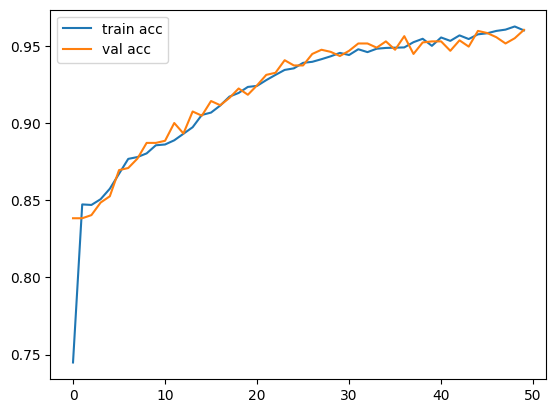

In [46]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [47]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.1079, Test acc: 0.9620


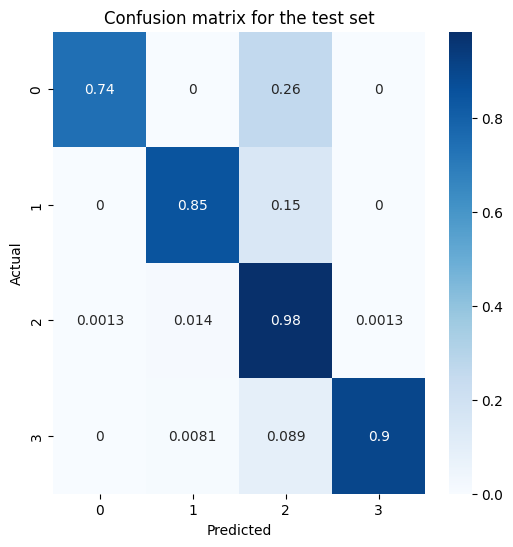

In [48]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

This is better overall, however we can see that the model is struggly with the 3rd class, as it's confusing it with other classes. It's because the class is more present in the dataset. The LSTM architecture is not suited for this kind of problem as its sensitive to the class imbalance.

In [71]:
y_train["new_labels"].value_counts()

new_labels
2    6222
1     580
3     429
0     126
4       7
Name: count, dtype: int64

## 3. Supervised classifiers

### a. Decision Tree

#### Multiclass classification

We will not use the Decision Tree for the binary classification, as we want to focus on the features importance.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 41), (1842, 41), (7364, 2), (1842, 2))

Define the model with empirical parameters

In [50]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [51]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [52]:
preds = pipeline.predict(X_test)

In [53]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9467969598262758
Recall:  0.6881698674841034
F1:  0.7326219385662255
MCC:  0.8133878482930105
Balanced accuracy:  0.6881698674841034


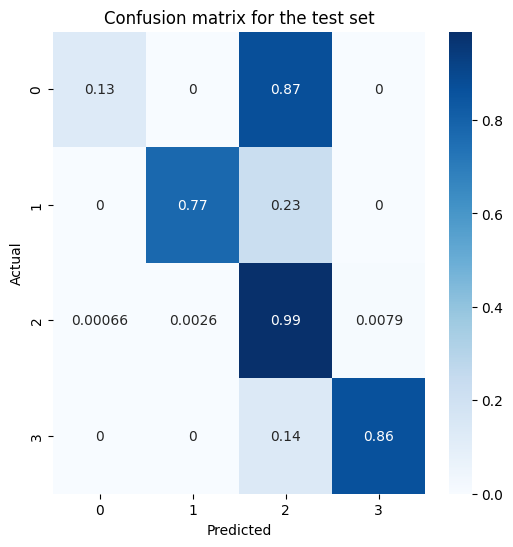

In [54]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

The decision tree is very sensitive to data imbalance, explaining the bad results.

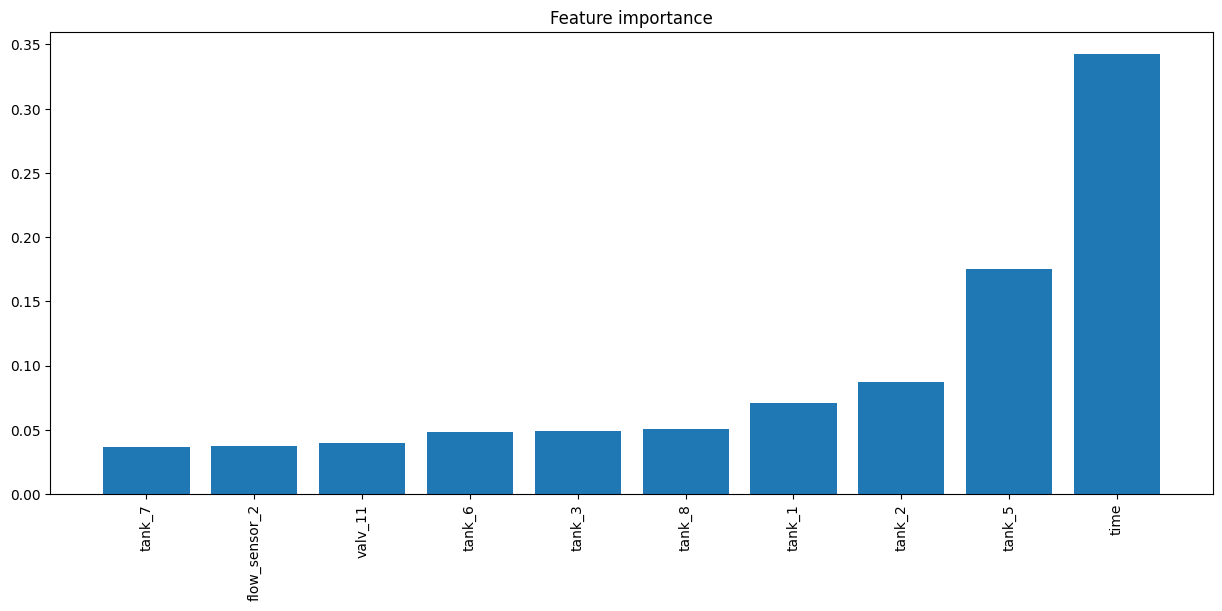

In [55]:
def plot_feature_importance(clf):
    importance = clf.feature_importances_
    # keep 10 most important features
    idx = np.argsort(importance)[-10:]
    importance = importance[idx]

    # plot feature importance
    plt.figure(figsize=(15, 6))
    plt.title("Feature importance")
    plt.bar([x for x in range(len(importance))], importance)
    plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
    plt.show()

plot_feature_importance(clf)

#### Without contextual information

In [56]:
df_physical_no_context = remove_physical_contextual_columns(df_physical)
df_physical_no_context

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,attack
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201,4,1037,7,452,300,432,80,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9202,3,1059,7,439,296,431,88,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9203,4,1091,8,429,291,431,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9204,4,1131,8,417,288,421,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0


In [57]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical_no_context)
df_physical_prepared.head()

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 40), (1842, 40), (7364, 2), (1842, 2))

In [59]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [60]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [61]:
preds = pipeline.predict(X_test)

In [62]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9098805646036916
Recall:  0.6005756884527672
F1:  0.6716904212164876
MCC:  0.6660129300122372
Balanced accuracy:  0.6005756884527672


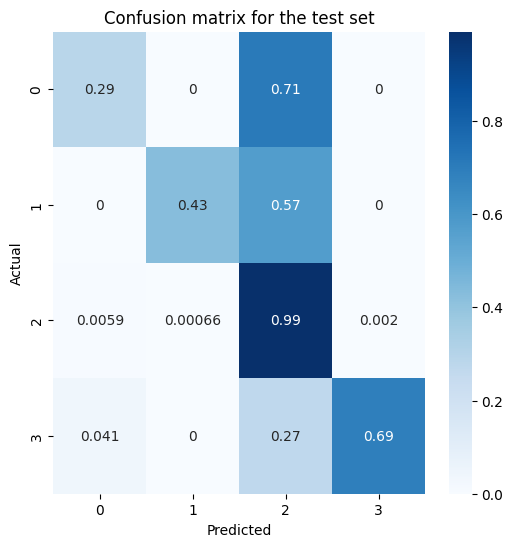

In [63]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

It is still not great, but it's better than before. We will try to fix this by using the `class_weight` parameter.

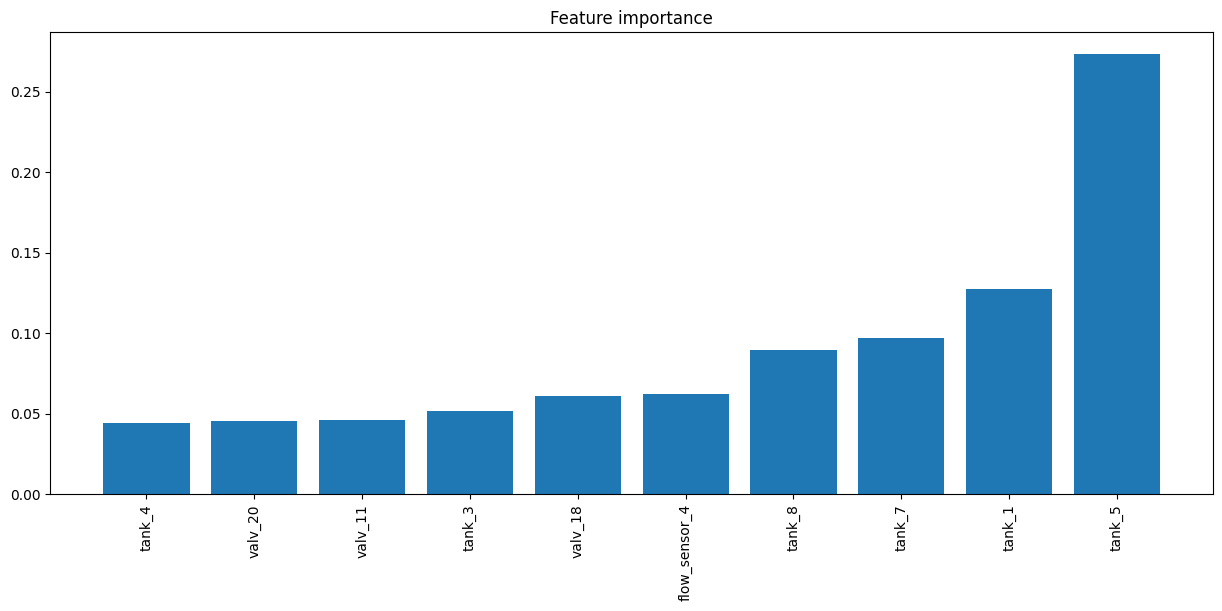

In [64]:
plot_feature_importance(clf)

Accuracy:  0.8610206297502715
Recall:  0.905293469919902
F1:  0.8210253799620744
MCC:  0.6657174507771821
Balanced accuracy:  0.905293469919902


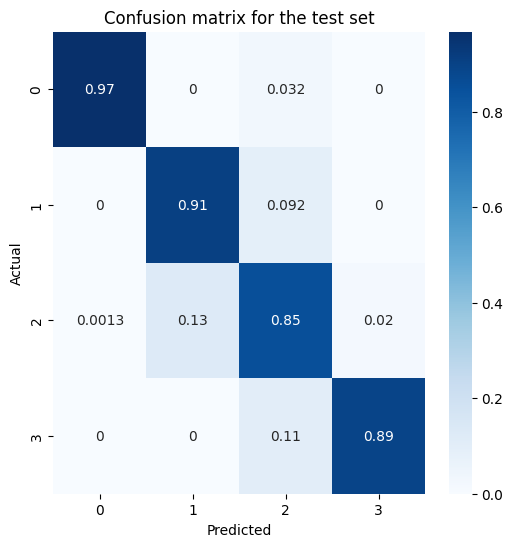

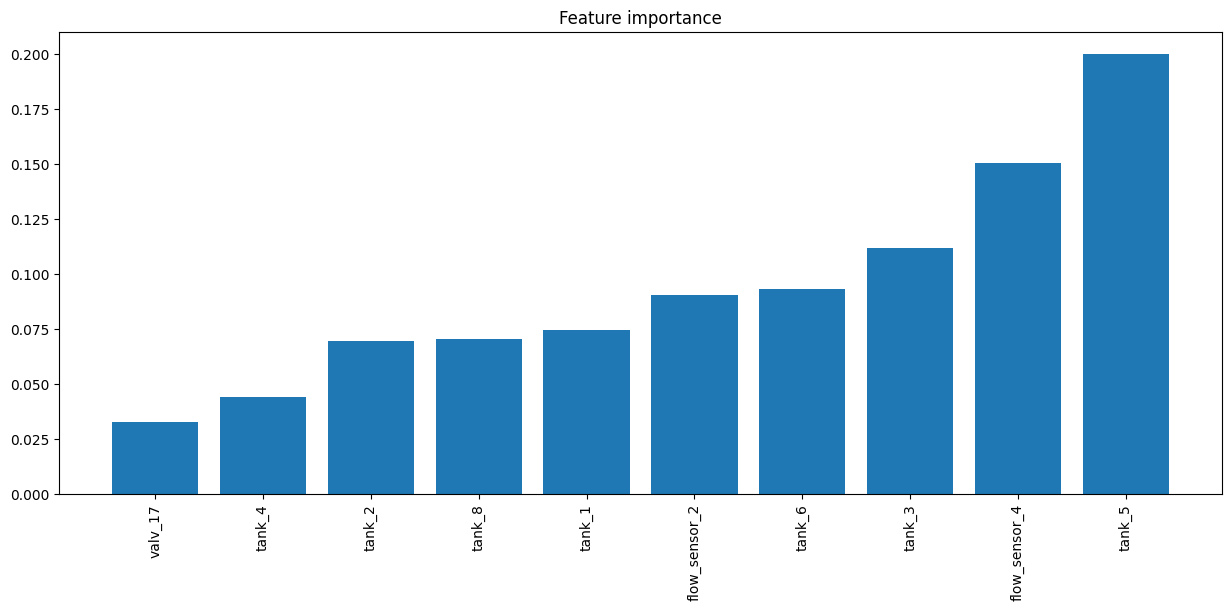

In [80]:
# class weight training on decision tree
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state,
    'class_weight': 'balanced'
}

clf = DecisionTreeClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

# remove 4th class
X_train = X_train[y_train["new_labels"] != 4]
y_train = y_train[y_train["new_labels"] != 4]
X_test = X_test[y_test["new_labels"] != 4]
y_test = y_test[y_test["new_labels"] != 4]

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

plot_feature_importance(clf)

After applying the balanced class weight, the results are better. The model is able to detect 100% of the anomalies, but it has a lot of confusion between 2->1 and 3->2.

### b. Random Forest

Let's apply the balanced class weights everytime from now on.

Accuracy:  0.9201954397394136
Recall:  0.9509380587101528
F1:  0.8842700752905684
MCC:  0.7889849844064595
Balanced accuracy:  0.9509380587101528


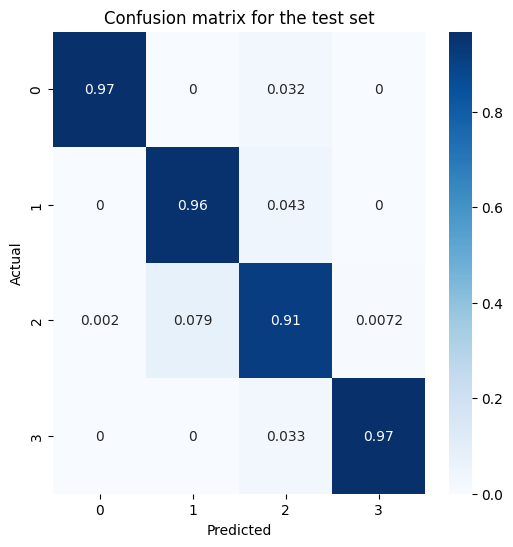

In [81]:
# random forest classification on the X_train, X_test, y_train, y_test datasets
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': 8,
    'criterion': 'gini',
    'n_estimators': 100,
    'random_state': 42,
    'class_weight': 'balanced'
}

clf = RandomForestClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

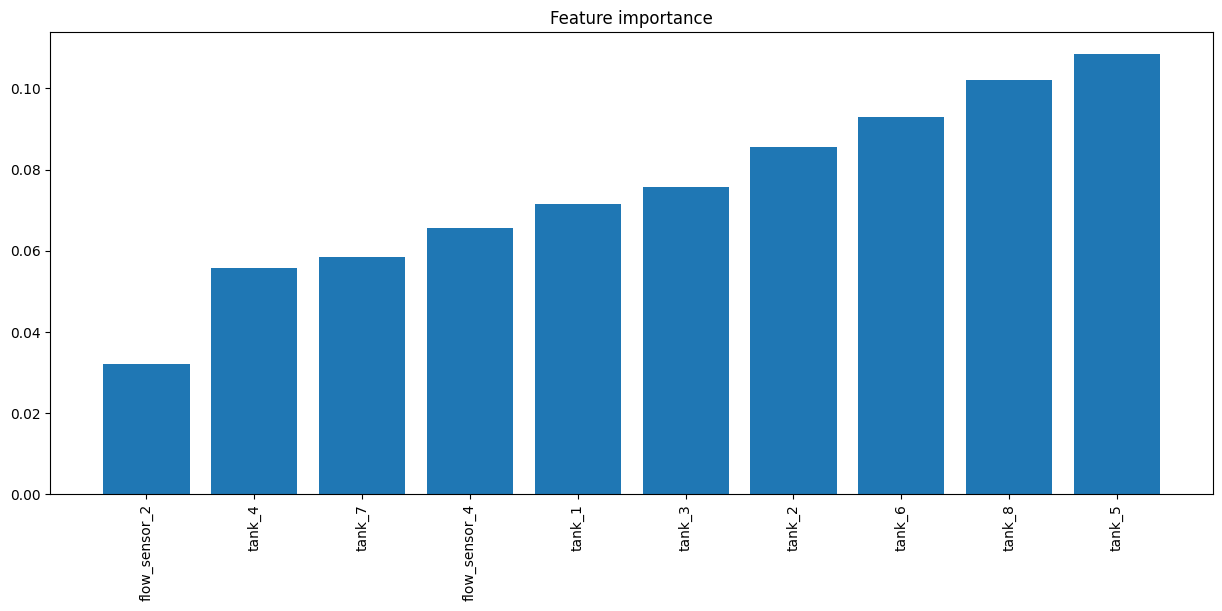

In [82]:
plot_feature_importance(clf)

Solid results.

### c. XGBoost

c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [19:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy:  0.990228013029316
Recall:  0.9688472058897267
F1:  0.9791810382614426
MCC:  0.9673650912082422
Balanced accuracy:  0.9688472058897267


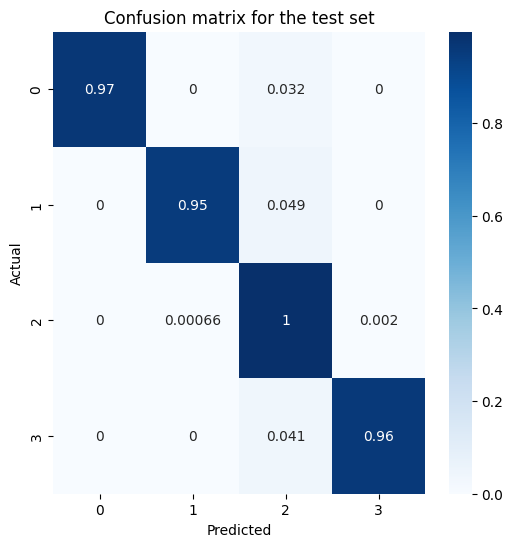

In [86]:
# xgboost classification on the X_train, X_test, y_train, y_test datasets
from xgboost import XGBClassifier

params = {
    'max_depth': 8,
    'n_estimators': 100,
    'random_state': 42
}

clf = XGBClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

The XGBoost model is the best so far, with almost 97% Recall and 99% Accuracy.

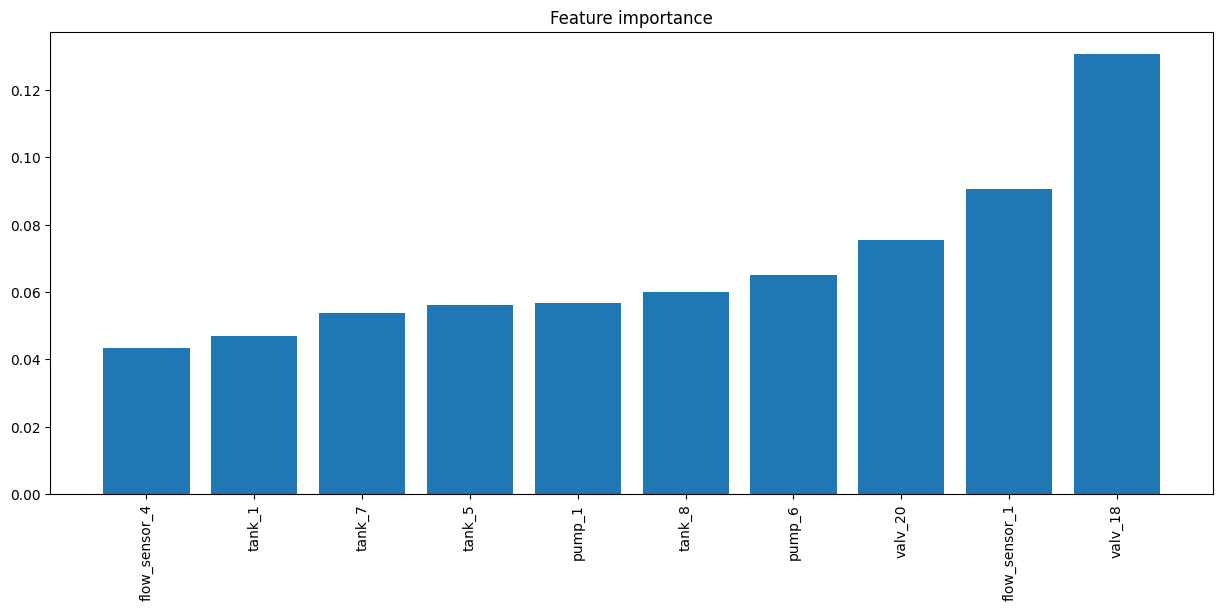

In [84]:
plot_feature_importance(clf)